# Classify images of soda bottles 

In [31]:
from fastai.vision import *

## Download images from a list of URLs

In [32]:
# Path object for directory containing data
path = Path('data/brands')

# Create subdirectory for pepsi images
folder = 'pepsi'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
# Download and save pepsi images
file = 'urls_pepsi.csv'
download_images(path/file, dest, max_pics=200)

# Create subdirectory for coke images
folder = 'coke'
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)
dest = path/folder
# Download and save coke images
file = 'urls_coke.csv'
download_images(path/file, dest, max_pics=200)

In [33]:
classes = ['coke', 'pepsi']

Remove any images that can't be opened:

In [34]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

coke


pepsi


## View data

- Create `data` object of type `ImageDataBunch`.
- Use 20% of images for validation.
- Rescale images to be size 224px.
- Normalize images to match the imagenet dataset. (for transfer learning)


In [58]:
np.random.seed(42)

# data = ImageDataBunch.from_folder(
    # path,
    # train=".",
    # valid_pct=0.2,
    # ds_tfms=get_transforms(),
    # size=224,
    # num_workers=4
# ).normalize(imagenet_stats)

data = ImageDataBunch.from_csv(
    path,
    folder=".",
    valid_pct=0.2,
    csv_labels='cleaned.csv',
    ds_tfms=get_transforms(),
    size=224,
    num_workers=4
).normalize(imagenet_stats)

Show an example of images & labels in our dataset.

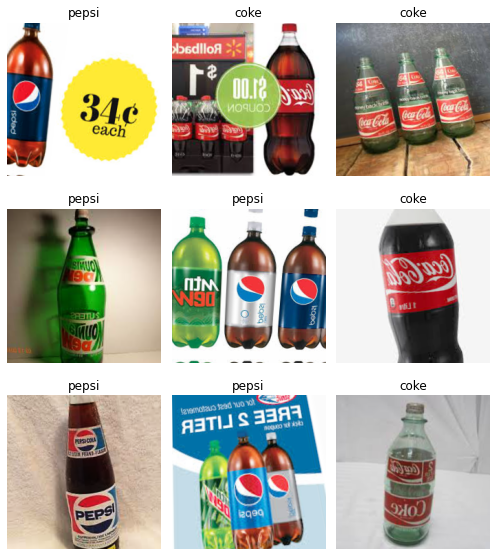

In [6]:
data.show_batch(rows=3, figsize=(7,8))

In [59]:
# Number of images in datasets: training and validation
len(data.train_ds), len(data.valid_ds)

(89, 22)

## Train model

In [60]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [61]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.274083,2.677301,0.545455,00:01
1,1.218893,0.739485,0.318182,00:01
2,0.979221,0.703989,0.181818,00:01
3,0.798513,0.730880,0.181818,00:01


In [62]:
learn.save('stage-1')

In [63]:
learn.unfreeze()

In [64]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


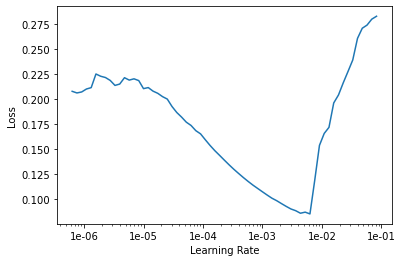

In [65]:
learn.recorder.plot()

In [66]:
learn.fit_one_cycle(2, max_lr=slice(1e-4, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.248914,0.596354,0.181818,00:01
1,0.227011,0.288972,0.090909,00:01


In [67]:
learn.save('stage-2')

## Interpretation

In [68]:
learn.load('stage-2');

In [69]:
interp = ClassificationInterpretation.from_learner(learn)

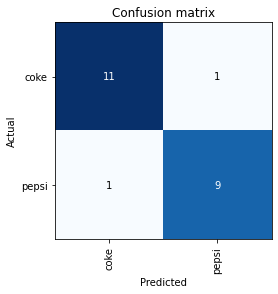

In [70]:
interp.plot_confusion_matrix()

## Cleaning up

In [53]:
from fastai.widgets import *

In [54]:
db = (ImageList.from_folder(path)
      .split_none()
      .label_from_folder()
      .transform(get_transforms(), size=224)
      .databunch()
      )

In [55]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2');

In [56]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [57]:
ImageCleaner(ds, idxs, path)

'No images to show :)'

## Export the model

In [72]:
learn.export()